In [55]:
# for data
import numpy as np
import pandas as pd
# web scraping
from bs4 import BeautifulSoup
import requests
import re
# datetime processing
import time
from datetime import date
import datetime
from dateutil.relativedelta import relativedelta
# plots and regression
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression
# encoding
from bidi import algorithm as bidialg

import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [56]:
# global settings for saving portfolio data to file 
filedate = datetime.datetime.now().strftime("%Y-%m-%d")

# Contents

* [Get current prices from the web](#get_data)
* [Rebalancing](#rebalancing)
    * [Calculations for rebalancing](#rebalancing_calc)
    * [Rebalancing visualisation](#rebalancing_vis)
* [History data](#history)
    * [Get history data](#history_get_data)
    * [Prepare the data for visualization](#history_preprocess)
    * [History data visualisation](#history_vis)
* [Correlation matrix](#corr)
* [Extrapolation of history data](#extrapolation)
* [Next steps](#next)

## Task description
In this project we will observe one porfolio, it's asset's current values and changes during last year. <br>Will make a calculations for rebalancing, will visualize current state and last year prices vs target proportion. <br>Also will make some extrapolations, keeping in mind all the limitations of this approach in stock market predictions.
<br>
As a result will see how much to buy/sell to keep the portfolio balanced and maybe will know when to do it.

<br>It's passive invested portfolio, so we have a target amounts of assets. Also there is a minimal amount to buy set by broker. <br> Will define target proportions and broker limitations here:

In [57]:
# target percents to keep assets proportion when rebalancing
percent_list = [14, 8, 8, 25, 18, 11, 12, 4]
print(sum(percent_list)) # to check it's 100%
# limitations of broker to buy minimal amount
min_buy  = [1, 1, 1, 2, 1, 48, 1, 16]

100


# 1. Get current prices from the web <a class="anchor" id="get_data"></a>

Some assets are in USD, some in ILS, so we will need to get a currency. Will use it in the simple coversation function.

In [58]:
#get ILS to USD currency
def get_currency_usd_to_ils():
    page = requests.get('https://www.x-rates.com/calculator/?from=USD&to=ILS&amount=1')
    soup = BeautifulSoup(page.text, 'html.parser')
    part1 = soup.find(class_="ccOutputTrail").previous_sibling
    part2 = soup.find(class_="ccOutputTrail").get_text(strip=True)
    currency_date = soup.find(class_="calOutputTS").get_text(strip=True)
    rate = float("{}{}".format(part1,part2))
    return rate

In [59]:
# test - print the currency
get_currency_usd_to_ils()

3.334264

Set a list of sites to get the data

In [60]:
# set none for commented lines
site1, site2, site3, site4, site5, site6, site7, site8 = [None]*8
# sites list
site1 = 'https://www.bizportal.co.il/mutualfunds/quote/graphs/5116181' # MTF govern
site2 = 'https://www.bizportal.co.il/mutualfunds/quote/generalview/5118021' # KTF bond 60
site3 = 'https://www.bizportal.co.il/mutualfunds/quote/generalview/5113402' #KTF makam
site4 = 'https://www.bizportal.co.il/forex/quote/generalview/1159250' #ISHARES S&P500
site5 = 'https://finance.yahoo.com/quote/EFAX/?guccounter=1&guce_referrer=aHR0cHM6Ly9kdWNrZHVja2dvLmNvbS8&guce_referrer_sig=AQAAAJ1B6k2pmd971gIcxfnPorEh1ExLM7mvpHymThrfVLQ-1K98KRuUBPXjxicuKqoSELF9Fu07rPuwv7WMLJfRXfKtTY1Qgn39emePCmWstX2tKhxRIxPcM71QbkujU7f7isuAqMIdZuCj8HR6FtsHiTrO6FlsI0nmAF9Swsibu-NA' # EFAX
site6 = 'https://www.bizportal.co.il/tradedfund/quote/generalview/1150549' # RUSSEL 2000
site7 = 'https://www.bizportal.co.il/mutualfunds/quote/generalview/5109889' # MTF TLV 125
site8 = 'https://www.bizportal.co.il/forex/quote/generalview/1159169' # ISHARES EM

In [61]:
def compose_site_list(sites_list):
    sites_list = [x for x in sites_list if x != None]
    return sites_list

In [62]:
# clean list for tests of parts
sites_list = compose_site_list([site1, site2, site3, site4, site5, site6, site7, site8])
# sites_list

In [63]:
# use in case of source change 
def print_data_list(data):
    for element in enumerate(data):
        print('element number', element[0], element[1])

Function to get the data

In [64]:
def get_today_stock_data_bizportal(sites_list):
    usd_ils_rate = get_currency_usd_to_ils()
    
    title_list = []
    price_list = []
    
    # web scraping
    header = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36',
    }
    markers = ['mutualfunds', 'forex', 'tradedfund', 'EFAX'] # to choose appropriate regex set
    for site in sites_list:
        webpage_response = requests.get(site, headers=header)
        webpage = webpage_response.content
        soup = BeautifulSoup(webpage, 'html.parser')
        time.sleep(1) # to be patient in data scrapping
        
        # data processing
        data = [element.text for element in soup.find_all("span")]
        data_num = [element.text for element in soup.find_all("div")]
        title = data[2]
            
        # in case it is mutualfunds
        if markers[0] in site:
            price = [element.text for element in soup.find_all("div")][2].split('\n')[3]
        
         # in case it is forex or tradedfund
        elif markers[1] in site:
            # print_data_list(data) # check the changes
            price = data[6].replace(',', '')
        
        elif markers[2] in site:
            # print_data_list(data) # check the changes
            price = data[3].replace(',', '')    
        
        #for EFAX
        elif markers[3] in site:
            data = [element.text for element in soup.find_all("fin-streamer")] 
            title = ' '.join([element.text for element in soup.find_all("title")][0].split(',')[0].replace(' Stock Price', '').split(' ')[3:9])
            price = float(data[18]) * usd_ils_rate * 100 # 100 for ils to agr
        
        # save titles and prices
        title_list.append(title)
        price_list.append(price)
        
    # construct the dataframe
    stocktable = pd.DataFrame({'title':  title_list, 'price AGR': price_list})
    convert_dict = {'title': str, 'price AGR': float}
    stocktable = stocktable.astype(convert_dict)
    stocktable['price ILS'] = stocktable['price AGR'].div(100)
    
    # save table to csv file
    filedate = datetime.datetime.now().strftime("%Y-%m-%d")
    stocktable.to_csv('stocktable_b_'+filedate+'.csv')

    return stocktable

In [65]:
stocktable = get_today_stock_data_bizportal(sites_list)

Will show all assets in ILS and also agorots, as it common to use in asset pricing

In [66]:
stocktable

,title,price AGR,price ILS
0,"MTF מחקה אג""ח ממשלתיות",128.51,1.29
1,קסם KTF תל בונד 60,122.71,1.23
2,"קסם KTF מק""מ",110.89,1.11
3,ISHARES CORE S&P 500 UCITS ETF,"140,140.00","1,401.40"
4,Fossil Fuel Reserves Free ETF (EFAX),"23,693.28",236.93
5,"MTF סל RUSSELL 2000 מנוטרלת מט""ח","3,411.00",34.11
6,"MTF מחקה ת""א 125",217.32,2.17
7,ISHARES CORE MSCI EM IMI UCITS ETF,"10,390.00",103.90


# 2. Rebalancing  <a class="anchor" id="rebalancing"></a>

## Calculations for rebalancing <a class="anchor" id="rebalancing_calc"></a>
One time in some period we want to rebalance the portfolio - to buy (or sell) some assets  to keep it close to the target proportions, it increases the long-run growth

In [1]:
#stocktable_model constructor (wanted percents and current assets)
def update_stocktable_pcs(df, pcs_list):
    title_list = list(df.title)
    global percent_list, min_buy
    stocktable_model_dct = {'title':  title_list,
                            'percent_target': percent_list,
                            'pcs': pcs_list,
                            'min_buy_pcs': min_buy,           
                    }
    stocktable_model = pd.DataFrame(stocktable_model_dct)
    
    df = pd.merge(df, stocktable_model, how='right', on='title')
    
    # add calculated fields
    df['value'] = df['pcs'] * df['price ILS']
    df['percent_real'] = (df['value'] / df['value'].sum()) * 100
    df['percent_diffference'] = df['percent_target'] - df['percent_real'] 
    total = df['value'].sum()
    df['value_difference'] = total/100 * df['percent_diffference']
    df['min_buy_value'] = min_buy * df['price ILS']
    df['should_buy_pcs']=(df['value_difference']/df['price ILS']).astype(int)
    
    return df

Here we input the current amounts of assets in portfolio (by list of pcs for every asset) and update the table

In [109]:
# current amounts of assets
pcs_list = [9000, 5500, 6400, 18, 71, 305, 5000, 50]
stocktable_large = update_stocktable_pcs(stocktable, pcs_list)

In [110]:
stocktable_large = stocktable_large[stocktable_large.columns[[0, 1, 2, 4, 6, 7, 3, 8, 9, 10, 5, 11]]]

Now we have the table with every asset, it's value in portfolio, target and real percents and the amount we should buy/sell to rebalance

In [111]:
stocktable_large

,title,price AGR,price ILS,pcs,value,percent_real,percent_target,percent_diffference,value_difference,min_buy_value,min_buy_pcs,should_buy_pcs
0,"MTF מחקה אג""ח ממשלתיות",128.51,1.29,9000,"11,565.90",12.31,14,1.69,"1,583.44",1.29,1,1232
1,קסם KTF תל בונד 60,122.71,1.23,5500,"6,749.05",7.19,8,0.81,764.86,1.23,1,623
2,"קסם KTF מק""מ",110.89,1.11,6400,"7,096.96",7.56,8,0.44,416.95,1.11,1,376
3,ISHARES CORE S&P 500 UCITS ETF,"140,140.00","1,401.40",18,"25,225.20",26.86,25,-1.86,"-1,744.23","2,802.80",2,-1
4,Fossil Fuel Reserves Free ETF (EFAX),"23,693.28",236.93,71,"16,822.23",17.91,18,0.09,84.07,236.93,1,0
5,"MTF סל RUSSELL 2000 מנוטרלת מט""ח","3,411.00",34.11,305,"10,403.55",11.08,11,-0.08,-71.92,"1,637.28",48,-2
6,"MTF מחקה ת""א 125",217.32,2.17,5000,"10,866.00",11.57,12,0.43,404.87,2.17,1,186
7,ISHARES CORE MSCI EM IMI UCITS ETF,"10,390.00",103.90,50,"5,195.00",5.53,4,-1.53,"-1,438.04","1,662.40",16,-13


As a conclusion it will be better to look at the next simple table (only titles and amount to buy/sell) <br>
<i>*Of course it's not worth rebalancing for small amounts because of broker's commission</i>

In [112]:
stocktable_large[stocktable_large.columns[[0, -1]]]

,title,should_buy_pcs
0,"MTF מחקה אג""ח ממשלתיות",1232
1,קסם KTF תל בונד 60,623
2,"קסם KTF מק""מ",376
3,ISHARES CORE S&P 500 UCITS ETF,-1
4,Fossil Fuel Reserves Free ETF (EFAX),0
5,"MTF סל RUSSELL 2000 מנוטרלת מט""ח",-2
6,"MTF מחקה ת""א 125",186
7,ISHARES CORE MSCI EM IMI UCITS ETF,-13


In [113]:
def print_changes(df, invested):
    total = df['value'].sum()
    print('Potrfolio:')
    print('Current sum','{:.2f}'.format(total), 'ILS')
    print('Invested   ', invested, 'ILS')
    print('Change    {:.2f}%'.format(((total/invested)-1)*100))
    print('After tax', '{:.2f}%'.format(((total/invested)-1)*100*.75))

If we want to know how the portfolio changed we can print out the numbers

In [114]:
invested = 100000 # year before
print_changes(stocktable_large, invested)

Potrfolio:
Current sum 93923.89 ILS
Invested    100000 ILS
Change    -6.08%
After tax -4.56%


## Rebalancing visualisation <a class="anchor" id="rebalancing_vis"></a>
It's better to see those gaps we want to rebalance, let's visualise the portfolio assets values

In [116]:
# plot barchart of assets
def plot_barchart(stocktable_large):
    global filedate
    plt.subplots(figsize = (7, 8))
    palette = sns.color_palette('Dark2')

    title_bidied = [bidialg.get_display(list(stocktable_large.title)[i]) for i in range(len(stocktable_large.title))]

    sns.barplot(data=stocktable_large, x=title_bidied, y='percent_target', ci=None, alpha=.3, color='gray', edgecolor='black', linewidth=1)

    g = sns.barplot(data=stocktable_large, x=title_bidied, y='percent_real', ci=None, palette=palette, alpha=.6)

    # show values on barplot
    for index, row in stocktable_large.iterrows():
        g.text(index, row.percent_real//2, round(row.percent_real, 2), color='black', ha="center", weight='bold')

    for index, row in stocktable_large.iterrows():
        g.text(index, row.percent_target+0.3, str(round(row.percent_target, 2))+'%', color='#6a6a6a', ha="center")

    plt.xticks(rotation = 90)
    plt.xlabel('Assets')
    plt.ylabel('Allocation percent')
    plt.title('Assets allocations')
    plt.tight_layout()
    plt.savefig(filedate+'assets_bars.png')

Now we can plot a current portfolio assets distribution compared to target percents<br>
It could help us to see which assets we want to rebalbance

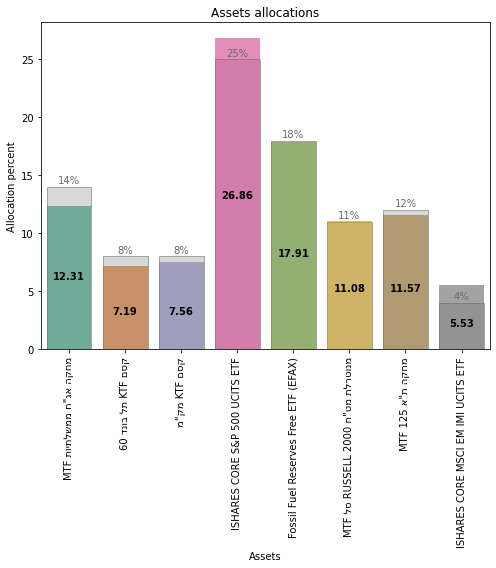

In [117]:
plot_barchart(stocktable_large)

On this barchart we see the current percents of assets (by different colors) and the gray target percent behind.<br>The gaps are easy to be pointed

In [118]:
# plot as a pie
def plot_pie(stocktable_large):
    global filedate
    title_bidied = [bidialg.get_display(list(stocktable_large.title)[i]) for i in range(len(stocktable_large.title))]
    plt.pie(stocktable_large.percent_real,
            labels=title_bidied,
            autopct='%0.1f%%',
            startangle=90,
            colors = sns.color_palette('Dark2'),
            counterclock=False,
            labeldistance=1.1
           )
#     plt.legend(bbox_to_anchor = [2.8, 1])
    plt.savefig(filedate+'assets_pie.png')
    plt.title('Assets allocations')
    plt.show()

It is controversial idea to plot so many assets as a pie chart, let's test it anyway

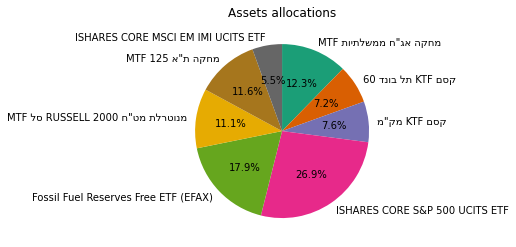

In [119]:
plot_pie(stocktable_large)

# 3. History data  <a class="anchor" id="history"></a>
In this part we will collect the data from the last year and will plot it as an areaplot, absolute values and normalized. <br> Will see there an absolute change and a relative change

### Get history data <a class="anchor" id="history_get_data"></a>

#### Functions to get data from sites

In [120]:
# get history funds # 1 # 2 # 3
def get_history_funds(site):
    # parcer
    header = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36',
    }
    webpage_response = requests.get(site, headers=header)
    webpage = webpage_response.content
    soup = BeautifulSoup(webpage, 'html.parser')   
    
    # format table
    title = [element.text.rstrip().replace('\r\n\t','') for element in soup.find_all("title")][0]
    print(title)
    # title_num = re.findall("\d+", title)[1]
    json_raw = str(soup.find_all('script')[6]).split('var fundGraphData = ')[1]\
                                        .split('var fundGraph2Data =')[0]\
                                        .split('{"x":')[1].split('};')[0]

    dataprices = pd.read_json(json_raw)
    dataprices.rename(columns = {'c':'date', 'p':title}, inplace = True)
    dataprices.date = pd.to_datetime(dataprices['date'], format='%Y-%m-%d')
    dataprices[title] = dataprices[title].astype("float")
    current_price_agr = dataprices[title].iloc[-1]
    
    return title, current_price_agr, dataprices

In [121]:
# get history data ISHARES # 4 # 8
def get_history_ishares(site):
    header = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36',
    }
    webpage_response = requests.get(site, headers=header)
    webpage = webpage_response.content
    soup = BeautifulSoup(webpage, 'html.parser')   

    ### format table
    title = [element.text.rstrip().replace('\r\n\t','') for element in soup.find_all("title")][0]
    print(title)
    # get current price
    current_price_usd = float(soup.find_all('span')[34].string.split(' ')[1])
    # title_num = re.findall("\d+", title)[1]
    # scripts = soup.find_all('script')
    # get json-like string
    json_raw = soup('script')[35].string.split(';')[2].replace('\nvar performanceData = ', '')
    # format like json
    json_raw_quoted = json_raw.replace('x:', '"x":"').replace(',y:','","y":"').replace(',formattedX','","formattedX"')
    # json to pandas
    dataprices_raw = pd.read_json(json_raw_quoted)
    # clean data
    dataprices_raw['date'] = pd.to_datetime(dataprices_raw['formattedX'], format='%a, %d %b %Y')
    dataprices_raw['price_cent'] = dataprices_raw.y.str.extract('(\d+.\d+)').astype(float)
    coefficient = dataprices_raw['price_cent'].iloc[-1] / current_price_usd
    dataprices_raw['price'] = dataprices_raw['price_cent'] / coefficient
    dataprices = dataprices_raw[['date', 'price']]
    dataprices = dataprices.rename(columns={'price':title})
    # plot to check visually
#     plt.plot(dataprices.date, dataprices.price_cent)
#     plt.grid()
#     plt.show()
    return title, current_price_usd, dataprices

In [122]:
# get yahoo history data # 5 # 6
def get_history_yahoo(site):
    # parcer
    header = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36',
    }
    webpage_response = requests.get(site, headers=header)
    webpage = webpage_response.content
    soup = BeautifulSoup(webpage, 'html.parser')   

    # get string data
    title = [element.text.rstrip().replace('\r\n\t','') for element in soup.find_all("title")][0].replace(' Historical Data - Yahoo Finance', '')
    if 'EFAX' in title:
        title = ' '.join(title.split(' ')[3:9])
    else:
        pass
    print(title)
    
    # prepare the json
    jason_str = str(soup.find_all('script')[54]).split('"HistoricalPriceStore":{"prices":')[1].split(',"isPending":')[0]
    # format table
    df = pd.read_json(jason_str)
    # there are also divs, it slighly changing the table, so will use this "try" to clean it
    try:
        df = df.drop(['amount', 'type', 'data'], axis=1).dropna()
    except KeyError:
        pass
    df['date'] = df['date'].dt.date
    dataprices = df[['date', 'adjclose']]
    dataprices.loc[: ,'date'] = pd.to_datetime(dataprices.loc[:, 'date'], format='%Y-%m-%d')

    # dataprices['date'] = dataprices['date'].dt.date
    dataprices = dataprices.rename(columns={'adjclose': title})
    dataprices.sort_values('date', inplace=True)
    current_price_usd = dataprices[title].iloc[-1]

    return title, current_price_usd, dataprices

#### Functions to get data by list of sites

In [123]:
def multy_funds(sites):
    for site in enumerate(sites):
        if site[0] == 0:
            title, current_price_agr, df = get_history_funds(site[1])
        else:
            title, current_price_agr, df_to_add = get_history_funds(site[1])
            df = pd.merge(df, df_to_add, how='right', on='date')
    return df

In [124]:
def multy_ishares(sites):
    for site in enumerate(sites):
        if site[0] == 0:
            title, current_price_agr, df = get_history_ishares(site[1])
        else:
            title, current_price_agr, df_to_add = get_history_ishares(site[1])
            df = pd.merge(df, df_to_add, how='right', on='date')
    return df

In [125]:
def multy_yahoo(sites):
    for site in enumerate(sites):
        if site[0] == 0:
            title, current_price_agr, df = get_history_yahoo(site[1])
        else:
            title, current_price_agr, df_to_add = get_history_yahoo(site[1])
            df = pd.merge(df, df_to_add, how='right', on='date')
    return df

#### Get prices from sites

In [126]:
### Sites to get funds history data from:
site1 = 'https://www.funder.co.il/fund/5116181' # 1 # MTF מחקה אג"ח ממשלתיות
site2 = 'https://www.funder.co.il/fund/5118021'   # 2 # KTF 60 תל בונד
site3 = 'https://www.funder.co.il/fund/5113402'   # 3 # קסם KTF מק"מ
site7 = 'https://www.funder.co.il/fund/5109889' # 7 # MTF  מחקה ת"א 125

sites_list = compose_site_list([site1, site2, site3, site7])

# get funds history table from this list
funds = multy_funds(sites_list)
# funds

MTF מחקה אג"ח ממשלתיות  - 5116181
קסם KTF  תל בונד 60 - 5118021
קסם KTFי מק"מ - 5113402
MTF מחקה ת"א 125  - 5109889


In [127]:
# Sites to get ISHARES history data (function for S&P500 and EM)
site4 = 'https://www.ishares.com/uk/individual/en/products/253743/ishares-sp-500-b-ucits-etf-acc-fund?switchLocale=y&siteEntryPassthrough=true#/' # 4 # S&P500
site8 = 'https://www.ishares.com/uk/individual/en/products/264659/ishares-msci-emerging-markets-imi-ucits-etf?switchLocale=y&siteEntryPassthrough=true#/' # 8 # EM

# get ishares history table from this list
ishares = multy_ishares([site4, site8])
# ishares

iShares Core S&P 500 UCITS ETF | CSPX
iShares Core MSCI EM IMI UCITS ETF | EIMI


In [128]:
# yahoo history # 5 # 6
site5 = 'https://finance.yahoo.com/quote/EFAX/history?p=EFAX'
site6 = 'https://finance.yahoo.com/quote/%5ERUT/history?p=%5ERUT'

yahoo = multy_yahoo([site5, site6])
# yahoo

Fossil Fuel Reserves Free ETF (EFAX)
Russell 2000 (^RUT)


### Prepare the data for visualization <a class="anchor" id="history_preprocess"></a>

#### Join assets in usd currency

In [129]:
df_usd = pd.merge(ishares, yahoo, on='date', how='right')
# df_usd

In [130]:
# convert usd to agr
def convert_usd_agr(df):
    rate = get_currency_usd_to_ils()
    cols = df.columns
    for col in cols[1:]:
        print(col)
        df[col] = df[col] * rate * 100
    return df

#### Convert USD to AGR to join with local assets

In [131]:
ishares_yahoo_agr = convert_usd_agr(df_usd)

iShares Core S&P 500 UCITS ETF | CSPX
iShares Core MSCI EM IMI UCITS ETF | EIMI
Fossil Fuel Reserves Free ETF (EFAX)
Russell 2000 (^RUT)


In [132]:
def another_russel_correction(df):
    coefficient = 181.6
    df['Russell 2000 (^RUT)'] = df['Russell 2000 (^RUT)']  / coefficient
    return df

In [133]:
# correction (synthetic asset)
ishares_yahoo_agr_corr = another_russel_correction(ishares_yahoo_agr)

#### Final join

In [134]:
history_prices = pd.merge(funds, ishares_yahoo_agr_corr)
# history_prices

#### Reorder assets columns 
(like in first barchart visualisation) to multiply further

In [135]:
history_prices_ordered = history_prices[history_prices.columns[[0, 1, 2, 3, 5, 7, 8, 4, 6]]]
# history_prices_ordered

#### Convert AGR to ILS

In [136]:
# convert agr to ils # less numbers
def convert_agr_ils(df):
    cols = df.columns
    for col in cols[1:]:
        df[col] = df[col] / 100
    return df

In [137]:
history_prices_ils = convert_agr_ils(history_prices_ordered)
history_prices_ils.head()

,date,"MTF מחקה אג""ח ממשלתיות - 5116181",קסם KTF תל בונד 60 - 5118021,"קסם KTFי מק""מ - 5113402",iShares Core S&P 500 UCITS ETF | CSPX,Fossil Fuel Reserves Free ETF (EFAX),Russell 2000 (^RUT),"MTF מחקה ת""א 125 - 5109889",iShares Core MSCI EM IMI UCITS ETF | EIMI
0,2021-06-03,1.35,1.27,1.11,"1,418.50",273.92,41.86,1.94,129.74
1,2021-06-07,1.34,1.27,1.11,"1,429.92",277.51,42.59,1.95,129.57
2,2021-06-08,1.34,1.27,1.11,"1,430.19",277.24,43.04,1.94,129.34
3,2021-06-09,1.34,1.27,1.11,"1,427.63",276.33,42.73,1.94,128.91
4,2021-06-10,1.34,1.27,1.11,"1,434.33",277.34,42.45,1.95,129.54


#### Multiply amount in portfolio by assets prices

In [138]:
# get the table ajusted for current portfolio
def multiply_by_amounts(df, pcs_list):
    for col in enumerate(df.columns[1:]):
#         print(col[1])
#         print(pcs_list[col[0]])
        df[col[1]] = df[col[1]] * pcs_list[col[0]]
    return df

In [139]:
portfolio = multiply_by_amounts(history_prices_ils, pcs_list)
portfolio.head()

,date,"MTF מחקה אג""ח ממשלתיות - 5116181",קסם KTF תל בונד 60 - 5118021,"קסם KTFי מק""מ - 5113402",iShares Core S&P 500 UCITS ETF | CSPX,Fossil Fuel Reserves Free ETF (EFAX),Russell 2000 (^RUT),"MTF מחקה ת""א 125 - 5109889",iShares Core MSCI EM IMI UCITS ETF | EIMI
0,2021-06-03,"12,106.80","6,978.40","7,109.76","25,532.95","19,448.50","12,765.88","9,689.50","6,486.90"
1,2021-06-07,"12,090.60","6,968.50","7,109.76","25,738.56","19,703.45","12,989.53","9,740.50","6,478.30"
2,2021-06-08,"12,078.90","6,970.15","7,110.40","25,743.43","19,684.39","13,127.20","9,724.00","6,467.17"
3,2021-06-09,"12,096.00","6,982.80","7,110.40","25,697.32","19,619.16","13,034.05","9,709.50","6,445.30"
4,2021-06-10,"12,096.00","6,985.00","7,110.40","25,817.91","19,691.28","12,946.01","9,740.50","6,476.82"


In [140]:
portfolio = portfolio.dropna()

In [141]:
def color_by_value(value, value_old):
    if value > value_old:
        color = '#006600' # green
    else:
        color = '#990000' # red
    return color

In [142]:
def plot_areachart(portfolio, norm=False):
    
    cols = [x for x in portfolio.columns]
    portfolio_plot = portfolio.copy(deep=True)
    portfolio_plot['total'] = portfolio_plot[portfolio_plot.columns[1:]].sum(axis=1)
    
    labels_bd = [bidialg.get_display(list(portfolio.columns[1:])[i]) for i in range(len(portfolio.columns[1:]))]

    if norm:
        for col in portfolio_plot.columns[1:-1]:
            portfolio_plot[col] = portfolio_plot[col] / portfolio_plot['total']
    else:    
        pass
            
    # plots
    plt.subplots(figsize=(14, 8))
    plt.stackplot(portfolio_plot[cols[0]], portfolio_plot[cols[1]], portfolio_plot[cols[2]], 
                  portfolio_plot[cols[3]], portfolio_plot[cols[4]], portfolio_plot[cols[5]], 
                  portfolio_plot[cols[6]], portfolio_plot[cols[7]], portfolio_plot[cols[8]],
                  labels=labels_bd, alpha=.5)
    
    # plot percents if normalized, adjust legend location
    if norm:
        # plot current percents
        y_coord = y_coord_old = 0
        for col in cols[1:]:
            value = portfolio_plot[col].iloc[-1]
            value_old = portfolio_plot[col].iloc[0]
            y_coord += value
            y_coord_old += value_old
            color = color_by_value(value, value_old)
            plt.text(portfolio_plot.date.iloc[-1], y_coord-.01, '{:.1%}'.format(value), weight='bold', color=color)
            plt.text(portfolio_plot.date.iloc[0], y_coord_old-.01, '{:.1%}'.format(value_old), ha='right')

        # plot lines and target percents to keep the balance
        y_coord = 0    
        for percent in percent_list:
            value = percent/100
            y_coord += value
            plt.axhline(y = y_coord, color = 'gray', linestyle = '--', alpha=.5) # , xmin=portfolio_plot.date.iloc[0]
            x_coord = portfolio_plot.date.iloc[0]+pd.Timedelta(len(portfolio_plot), unit="d")
            plt.text(x_coord, y_coord-.01, '{:.1%}'.format(value), ha="right", color='gray')
        plt.legend(bbox_to_anchor=(0.05, 0.6))
        plt.title('Normalized assets allocations by time, last year')
        plt.ylabel('Values, percents')
    # absolute values    
    else:
        y_coord = y_coord_old = 0
        for col in cols[1:]:
            value = portfolio_plot[col].iloc[-1]
            value_old = portfolio_plot[col].iloc[0]
            y_coord += value
            y_coord_old += value_old
            color = color_by_value(value, value_old)
            plt.text(portfolio_plot.date.iloc[-1], y_coord-.01, '{:.2f}'.format(value), color=color)
            plt.text(portfolio_plot.date.iloc[0], y_coord_old-.01, '{:.2f}'.format(value_old), ha='right')
        
        total = portfolio_plot['total'].iloc[-1]
        total_old = portfolio_plot['total'].iloc[0]
        plt.text(portfolio_plot.date.iloc[-1], total*1.05, '{:.2f}'.format(total), weight='bold', ha='center')
        plt.text(portfolio_plot.date.iloc[0], total_old*1.05, '{:.2f}'.format(total_old), weight='bold', ha='center')
        
        plt.legend(bbox_to_anchor=(0.33, 0.6))
        plt.title('Assets allocations by time, last year')
        plt.ylabel('Values, ILS')
        
    plt.xlabel('Date')
    plt.tight_layout()
    plt.grid()
    plt.show()

### History data visualisation <a class="anchor" id="history_vis"></a>

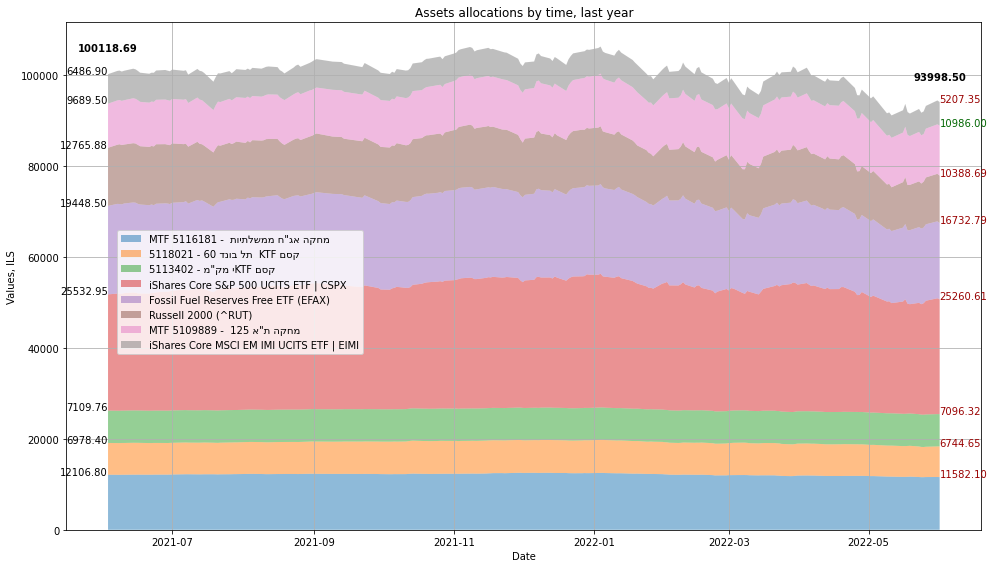

In [143]:
plot_areachart(portfolio, False)

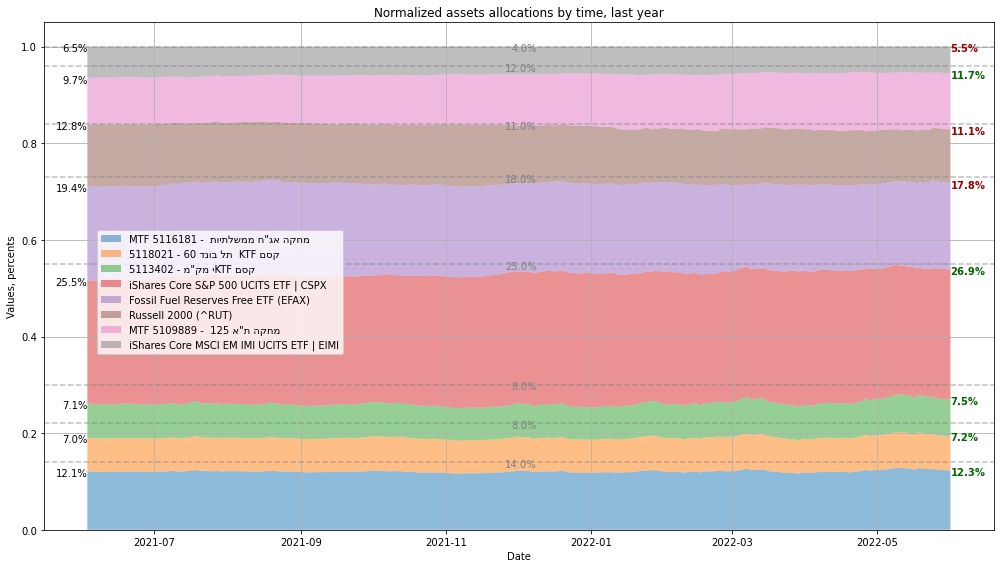

In [144]:
plot_areachart(portfolio, True)

We can see that there are more red numbers (decreased last year) on absolute scale, than relative. <br>Absolute chart is for general purpose when the normalized one is for rebalancing.

# 4. Correlation matrix <a class="anchor" id="corr"></a>
It's important to know how the assets in portfolio correlate, will visualise the portfolio correlation matrix

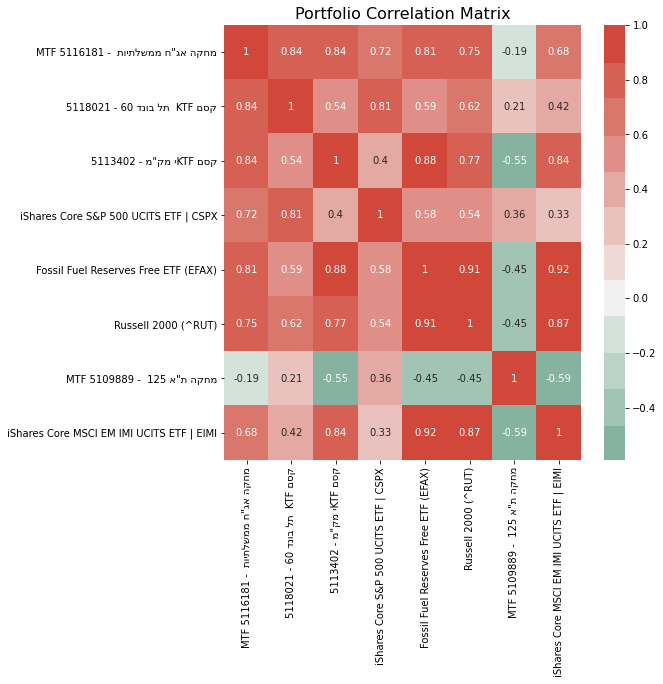

In [103]:
plt.figure(figsize=(8, 8))
color_scheme = sns.diverging_palette(150, 15, n=15)

ax = sns.heatmap(portfolio[1:-1].corr(), center=0, annot=True, cmap=color_scheme)
plt.title('Portfolio Correlation Matrix', fontsize=16)
plt.grid(False)

# fix hebrew text
title_bidied = [bidialg.get_display(list(portfolio.columns[1:])[i]) for i in range(len(portfolio.columns[1:]))]
ax.set_xticklabels(title_bidied)
ax.set_yticklabels(title_bidied)

plt.show()

We observe high correlation between assets, could be better combination for potfolio. That's why colors are inverted here and "less" is green

# 5. Extrapolation of history data  <a class="anchor" id="extrapolation"></a>
It's obvious that extrapolation of stock history is not the way to predict anything, still it can be useful to get the picture of trends

Let's assume we want to buy asset for best portfolio balance. Let's calculate and plot trends, for example with S&P500 asset<br>

In [104]:
# S&P500 ishares data from here
site4 = 'https://www.ishares.com/uk/individual/en/products/253743/ishares-sp-500-b-ucits-etf-acc-fund?switchLocale=y&siteEntryPassthrough=true#/' # 4 # S&P500
_, _, snp500_history = get_history_ishares(site4)

iShares Core S&P 500 UCITS ETF | CSPX


In [105]:
# some help functions
def prepare_for_extrapolation(df):
    df['title'] = df.columns[1]
    df = df.rename(columns={df.columns[1]: 'price'})
    df['daynumber'] = ((df.date - df.date[0]).astype(str).str.split()).str[0].astype(int)
    return df


def years_to_keep(df, years):
    start = df.date.iloc[-1] - relativedelta(years=years)
    result_df = df[df.date > start]
    return result_df


#slicer finctions
def slicer(object_to_slice, divider):
    index_to_slice = int(len(object_to_slice)/divider)
    new_object = object_to_slice[-index_to_slice:-1]
    return new_object


def LR_sliced(X, y, slicer_list, regr):
    X_list = []
    y_list = []
    for i in slicer_list:
        X_current = slicer(X,i)
        y_current = slicer(y,i)
        regr.fit(X_current, y_current)
        y_current_predict = regr.predict(X_current)
        X_list.append(X_current)
        y_list.append(y_current_predict)
    return X_list, y_list


def workdays(d, end, excluded=(5, 6)):
    days = []
    while d.date() <= end.date():
        if d.isoweekday() not in excluded:
            days.append(d)
        d += datetime.timedelta(days=1)
    return days


def get_future_dates(df, months):
    start = df.date.iloc[-1]
    finish = df.date.iloc[-1] + relativedelta(months=months)
    df = pd.Series(workdays(start,finish))
    return df


#tick tune for plots
def tick_tuner(daynumber, date, n):
    ticklist = []
    labellist = []
    for i in range(len(date) - n):
        if i % n == 0:
            ticklist.append(daynumber[i])
            labellist.append(date.iloc[i].strftime('%Y-%m-%d'))
    return ticklist, labellist

In [106]:
def plot_history_graph_extrp(df, years, months_to_extrapolate) -> plt:
    
    df = prepare_for_extrapolation(df)
    df = years_to_keep(df, years)
    

    X = np.array(df.daynumber)
    X = X.reshape(-1, 1)
    y = df.price

    regr = LinearRegression()
    regr.fit(X, y)
    y_predict = regr.predict(X)

    fig, ax = plt.subplots(figsize=(16,7))
    
    #future plot 
    X_future = np.array(range(int(X[-1]), int(X[-1]) + 30*months_to_extrapolate))
    X_future = np.array([x for x in X_future if not x%6 == 0 and not x%7 == 0])
    X_future = X_future.reshape(-1, 1)

    future_dates = get_future_dates(df, months_to_extrapolate)
    future_predict = regr.predict(X_future)

    # plot extrapolation
    ax.plot(X_future, future_predict, color = 'r', linestyle = 'dashed')

    # regression on parts of history
    slicer_list = [2, 4, 8]
    X_list, y_list = LR_sliced(X, y, slicer_list, regr)     

    #plot
    ax.scatter(X, y, s=4)
    ax.plot(X, y, alpha=.5)
    ax.plot(X, y_predict, color = 'gray', linestyle='--')
    ax.plot(X_list[0], y_list[0], color = 'gray', linestyle='--', alpha=.75)
    ax.plot(X_list[1], y_list[1], color = 'gray', linestyle='--', alpha=.5)
    ax.plot(X_list[2], y_list[2], color = 'gray', linestyle='--', alpha=.25)

    # ticks order
    daynumber_all = np.concatenate((X, X_future), axis=None)
    dates_all = df.date.append(future_dates)
    ticklist, labellist = tick_tuner(daynumber_all, dates_all, int(len(df)/50)) # days to skip on grid

    plt.title(df.title.iloc[0])
    plt.xticks(rotation=90)
    plt.xticks(ticks=ticklist, labels=labellist)
    plt.xlabel("days")
    plt.ylabel('price')
    plt.grid()

    plt.show()

Here we plot the history with trends (for all period, half and quarter of period) <br>
Function allow us to choose how many years to observe and how many months to extrapolate the trendline 

In [107]:
# test on different combinations of years and months
# for i in range(10, 1, -1):
#     print(i, 'years')
#     print(i*3, 'months to extrapolate')
#     plot_history_graph_extrp(snp500_history, i, 3*i)

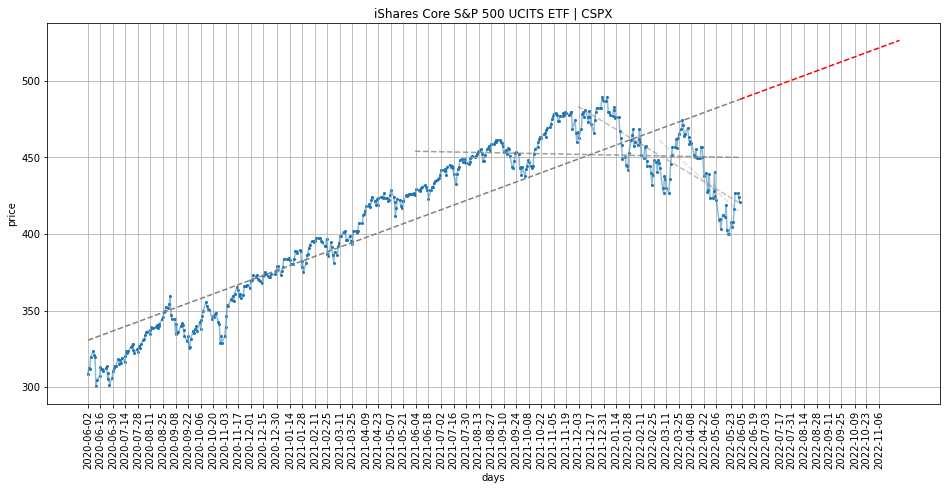

In [108]:
# dataframe, years to keep, months to extrapolate
plot_history_graph_extrp(snp500_history, 2, 6)

Of course trendline will be much different calculated by different periods. Anyway it can help to get the general picture by some different trendlines. <br>The current value can be above the year trend, but below the trend by two years

# Next steps  <a class="anchor" id="next"></a>
* Now all currency (USD/ILS) calculations made by current change rate only. More precise way is to get currency history data and multiply by it by dates respectively. <br>
* Another good thing to do is to calculate the frequencies to buy assets - getting the expected income ang broker's comission.<br>